# Skin Cancer Detection

### 1. Importing Libraries

In [1]:
# for data manipulation
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D , MaxPooling2D ,Dropout , Flatten , Dense ,BatchNormalization ,Concatenate ,Input 
from keras.models import Sequential ,Model

# SK Learn library to split train and test data
from sklearn.model_selection import train_test_split

# other libraries
import cv2
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

### 2. Loading Images

In [2]:
# loading the csv file

metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
label_mapping2 = {
    "nv": 0,
    "bkl": 0,
    "df": 0,
    "mel": 1,
    "vasc": 0,
    "bcc": 1,
    "akiec": 1
}

In [4]:
# # function to load_image data
# def load_image(image_id  , image_folder):
#     image_path = os.path.join(image_folder , f'{image_id}.jpg')
#     return Image.open(image_path)

In [5]:
# # Deleting Folder
# import shutil
# shutil.rmtree("/kaggle/working/")

In [6]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

# Directories for images
image_folder1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_folder2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

# Initialize lists for image data and labels
segmented_image_data = []
labels2 = []

# Function to segment an image
def segment_image(image_path):
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        return None  # Return None if the image could not be loaded

    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    
    # Draw contours
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
    
    # Apply mask to isolate lesion
    segmented = cv2.bitwise_and(image, image, mask=mask)
    
    return segmented

# Process images and labels
for idx, row in metadata.iterrows():
    image_id = row['image_id']
    dx = row['dx']
    
    # Construct the image path for each folder
    image_path1 = f"{image_folder1}/{image_id}.jpg"
    image_path2 = f"{image_folder2}/{image_id}.jpg"
    
    # Try to load and segment the image
    image = None
    if os.path.exists(image_path1):
        image = segment_image(image_path1)
    elif os.path.exists(image_path2):
        image = segment_image(image_path2)
    
    # If the image couldn't be loaded, skip it
    if image is None:
        print(f"Image not found or could not be read: {image_id}")
        continue

    # Resize the segmented image to the model's input size
    image = cv2.resize(image, (192, 192))
    image = img_to_array(image) / 255.0  # Normalize image to [0, 1]
    segmented_image_data.append(image)
    
    # Append labels
    # labels1.append(label_mapping[dx])
    labels2.append(label_mapping2[dx])

# Convert to NumPy arrays
X_segmented = np.array(segmented_image_data)
y_segmented = np.array(labels2)  # Assuming `label_mapping2` is for y

print(f"Total segmented images processed: {len(X_segmented)}")
print(f"Shape of X_segmented: {X_segmented.shape}")
print(f"Shape of y_segmented: {y_segmented.shape}")

Total segmented images processed: 10015
Shape of X_segmented: (10015, 192, 192, 3)
Shape of y_segmented: (10015,)


In [7]:
y_encoded = pd.get_dummies(y_segmented, dtype=int).values
print(f"Shape of y_segmented: {y_encoded.shape}")
y_encoded

Shape of y_segmented: (10015, 2)


array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [8]:
X_train_image, X_test_image, y_encoded_train ,y_encoded_test = train_test_split(X_segmented, y_encoded ,test_size=.2 ,random_state=42)

### 3.i. CNN + ANN Model

In [9]:
# # from tensorflow.keras.models import Sequential
# # from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# # Creating the CNN + ANN model
# model = Sequential()

# # Convolutional layers
# model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(192, 192, 3)))  # conv1
# model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))  # conv2
# model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))  # conv3
# model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))  # conv4
# model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))  # conv5
# model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# # Flattening
# model.add(Flatten())

# # Fully connected layers (ANN)
# model.add(Dense(256, activation='relu'))  # H₁
# model.add(Dropout(0.5))  # Adding dropout for regularization

# model.add(Dense(128, activation='relu'))  # H₂
# model.add(Dropout(0.5))

# model.add(Dense(64, activation='relu'))  # H₃

# # Output layer
# model.add(Dense(2, activation='softmax')) 


In [10]:
# model.summary()

In [11]:
# from tensorflow.keras import metrics

# # Model compilation with additional metrics
# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=[
#         'accuracy',
#         metrics.Precision(name='precision'),
#         metrics.Recall(name='recall')
#     ]
# )

In [12]:
# history = model.fit(
#     X_train_image, y_encoded_train, 
#     epochs=15, 
#     validation_data=(X_test_image, y_encoded_test)
# )

In [13]:
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Model - Accuracy')
# plt.show()

In [14]:
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], color='red', label='Training Loss')
# plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Model - Loss')
# plt.show()

### 3.ii. EfficientNet - Hyperparameter Tuned (with Trainable Parameters)

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [16]:
# Loading the EfficientNetB0 model pre-trained on ImageNet
base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Fine-tuning the model (unfreeze some layers of the base model)
base_model1.trainable = True

In [18]:
# model adjustments

# Adding custom classification head
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # Dropout to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # 7 output labels

# and defining the final model
model1 = Model(inputs=base_model1.input, outputs=output)

In [19]:
# Lowering the learning rate for fine-tuning
model1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# fitting the model
history_finetune1 = model1.fit(
    X_train_image, y_encoded_train,
    validation_data=(X_test_image, y_encoded_test),
    epochs=10,
    batch_size=16
)

Epoch 1/10


I0000 00:00:1732047144.858103      71 service.cc:145] XLA service 0x7eea1c0e94f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732047144.858156      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732047144.858160      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/501 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.1875 - loss: 0.9659    

I0000 00:00:1732047192.012602      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


501/501 ━━━━━━━━━━━━━━━━━━━━ 158s 161ms/step - accuracy: 0.7543 - loss: 0.4652 - val_accuracy: 0.7329 - val_loss: 0.6274
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.8631 - loss: 0.2947 - val_accuracy: 0.8637 - val_loss: 0.2924
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.8856 - loss: 0.2532 - val_accuracy: 0.8757 - val_loss: 0.2801
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.9193 - loss: 0.1918 - val_accuracy: 0.8577 - val_loss: 0.3145
Epoch 5/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.9441 - loss: 0.1403 - val_accuracy: 0.8692 - val_loss: 0.3390
Epoch 6/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.9637 - loss: 0.1035 - val_accuracy: 0.8752 - val_loss: 0.3579
Epoch 7/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.9710 - loss: 0.0792 - val_accuracy: 0.8772 - val_loss: 0.3879
Epoch 8/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.9714 - loss: 0.0690 - val_accur

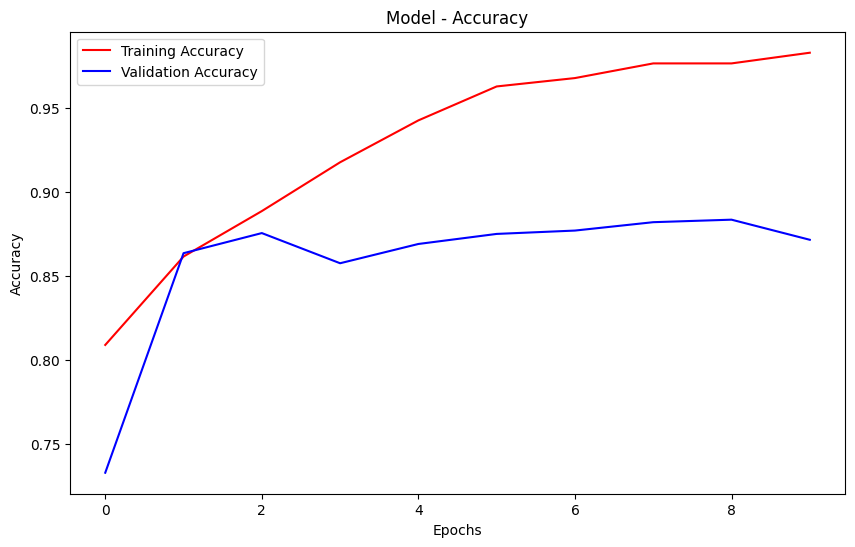

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(history_finetune1.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history_finetune1.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model - Accuracy')
plt.show()